In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib notebook

In [3]:
import calour as ca
import seaborn as sns
from scipy import stats
from calour.training import plot_roc
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, auc
from emperor import Emperor, nbinstall
from matplotlib.backends.backend_pdf import PdfPages

# new data table

In [4]:
exp = ca.read_amplicon('combined_apoe_ldlr_norare_2k_matched.qza',
                       sample_metadata_file='data/combined_sample_metadata_HFD.txt', 
                       feature_metadata_file='taxonomy.tsv',
                       data_file_type='qiime2', min_reads=100, normalize=100)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
exp

AmpliconExperiment ("combined_apoe_ldlr_norare_2k_matched.qza") with 642 samples, 2791 features

In [6]:
exp.feature_metadata.rename({'Taxon': 'taxonomy'}, inplace=True, axis=1)

In [7]:
exp.feature_metadata.head()

,taxonomy,Confidence,_feature_id
Feature ID,,,
AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCGCGTAGGTGGTCTGTTAAGTCAGATGTGAAATGTAAGGGCTCAACCCTTAACGTGCATCTGATACTGGCAGACTTGAGTGCGGAAGAGGCAAGTGGAATTCCTAG,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,1.000000,AACATAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGGGCG...
AACGAGGGGGGCTAGCGTTATTCATCTTGACTGGGCGTAAAAGGTTCGTAGATGGTAAAGTAAGTTTCTTGCTAAAAATTAAAGCCTAACTTTTAAAAGTTTGTAAATACTGCTTTACTTGAGTTTAATACGGGAGGGTATAATTTTATT,k__Bacteria; p__Proteobacteria; c__Alphaproteo...,0.989479,AACGAGGGGGGCTAGCGTTATTCATCTTGACTGGGCGTAAAAGGTT...
AACGTAGGAGGCGAGCGTTATCCGGATTTACTGGGTGTAAAGCGCGTGCAGGCGGTAAGCTAAGTTGGGTGTGAAAGCTCCTGGCTCAACTGGGAGAGGTCGCTCAAGACTGGCTAACTCGAGGATGGTAGGGGAAGGTGGAATTCCGGG,k__Bacteria; p__Chloroflexi; c__Anaerolineae; ...,1.000000,AACGTAGGAGGCGAGCGTTATCCGGATTTACTGGGTGTAAAGCGCG...
AACGTAGGGGGCAAGCGTTATCCGGATTCATTGGGCGTAAAGCACGCGCAGGCGGGCCGCTAAGCGGGACCTCTAATCTTGGGGCTCAACCTCAAGCCGGGTCCCGAACTGGCAGCCTCGAGTGCGGTAGGGGTAAGCGGAATTCCCGGT,k__Bacteria; p__Actinobacteria; c__Coriobacter...,0.999882,AACGTAGGGGGCAAGCGTTATCCGGATTCATTGGGCGTAAAGCACG...
AACGTAGGGGGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGCGCGCGCAGGCGGTCCTTTAAGTCTGATGTGAAATTCCGCGGCTCAACCGCGGGTGTGCATTGGAAACTGGGGGACTTGAGTGCGGAAGAGGGGAGCGGAATTCCCGG,k__Bacteria; p__Firmicutes; c__Bacilli; o__Bac...,0.999786,AACGTAGGGGGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGCGCG...


# APOE and LDLR models

In [8]:
exp2 = exp.filter_prevalence(field='genotype', cutoff=0.1, fraction=0.001)#.filter_samples('age', [10, 10.5], negate=True)
exp2

AmpliconExperiment ("combined_apoe_ldlr_norare_2k_matched.qza") with 642 samples, 1018 features

In [9]:
exp2_apoe = exp2.filter_samples('genotype', 'ApoE KO')

exp2_apoe.sample_metadata.exposure_type.value_counts()

Air    235
IHH    225
Name: exposure_type, dtype: int64

In [10]:
exp2_ldlr = exp2.filter_samples('genotype', 'LDLR KO')
exp2_ldlr.sample_metadata.exposure_type.value_counts()

IHH    92
Air    90
Name: exposure_type, dtype: int64

In [12]:
points = exp2_apoe.sample_metadata.age.unique()
points_accuracy = []
for i in np.sort(points):
    exp_ = exp2_apoe.filter_samples('age', i)
    it_apoe = exp_.classify('exposure_type',
                            RandomForestClassifier(n_estimators=500, random_state=9),
                            GroupKFold(5).split(exp_.data, exp_.sample_metadata['exposure_type'], exp_.sample_metadata['mouse_number']))
    res_apoe = next(it_apoe)
    s = roc_auc_score(res_apoe['Y_TRUE']=='IHH', res_apoe['IHH'])
    points_accuracy.append([i, s, exp_.shape[0]])

points_df = pd.DataFrame(points_accuracy, columns=['age', 'AUC', 'sample_size'])
points_df

,age,AUC,sample_size
0,10.0,0.937500,24
1,10.5,0.895833,24
2,11.0,1.000000,24
3,11.5,1.000000,23
4,12.0,1.000000,24
5,12.5,1.000000,23
6,13.0,1.000000,22
7,13.5,1.000000,22
8,14.0,1.000000,24
9,14.5,1.000000,24


In [13]:
points = exp2_ldlr.sample_metadata.age.unique()
points_accuracy = []
res_ = []
for i in np.sort(points):
    exp_ = exp2_ldlr.filter_samples('age', i)
    if exp_.shape[0] < 10: continue
    it = exp_.classify('exposure_type',
                        RandomForestClassifier(n_estimators=500, random_state=9),
                        GroupKFold(5).split(exp_.data, exp_.sample_metadata['exposure_type'], exp_.sample_metadata['mouse_number']))
    res = next(it)
    res['age'] = i
    res_.append(res)
    s = roc_auc_score(res['Y_TRUE']=='IHH', res['IHH'])
    points_accuracy.append([i, s, exp_.shape[0]])
res_df = pd.concat(res_, axis=0)
points_df = pd.DataFrame(points_accuracy, columns=['age', 'AUC', 'sample_size'])
points_df

,age,AUC,sample_size
0,11.0,0.750000,15
1,11.5,0.982143,15
2,12.0,0.750000,16
3,12.5,0.828125,16
4,13.0,0.910714,15
5,13.5,0.906250,16
6,14.0,1.000000,16
7,14.5,0.984375,16
8,15.0,1.000000,15
9,15.5,1.000000,15


# diff abundance

In [14]:
exp2_apoe_diff = exp2_apoe.diff_abundance('exposure_type', val1='Air', val2='IHH', alpha=0.01)

exp2_apoe_diff

AmpliconExperiment ("combined_apoe_ldlr_norare_2k_matched.qza") with 460 samples, 140 features

In [15]:
exp2_ldlr_diff = exp2_ldlr.diff_abundance('exposure_type', val1='Air', val2='IHH', alpha=0.01)
exp2_ldlr_diff

AmpliconExperiment ("combined_apoe_ldlr_norare_2k_matched.qza") with 182 samples, 78 features

In [16]:
exp2_apoe_diff.feature_metadata.rename({'_calour_diff_abundance_effect': 'apoe'}, axis=1, inplace=True)
exp2_ldlr_diff.feature_metadata.rename({'_calour_diff_abundance_effect': 'ldlr'}, axis=1, inplace=True)

In [17]:
fids_diff = set(exp2_apoe_diff.feature_metadata.index) & set(exp2_ldlr_diff.feature_metadata.index)

In [12]:
from sklearn.metrics import roc_auc_score

In [18]:
with open('microbes.tsv', 'w') as f:
    f.write('amplicon\tAPOE AUC\tLDLR AUC\ttaxonomy\n')
    for i in exp2.feature_metadata.index:
        taxon = exp2_apoe.feature_metadata.loc[i, 'taxonomy']
        apoe_score = exp2_apoe[:, i]
        apoe_true = exp2_apoe.sample_metadata['exposure_type'].values == 'IHH'
        a = roc_auc_score(apoe_true, apoe_score)
        if a < 0.5:
            a = 1 - a

        ldlr_score = exp2_ldlr[:, i]
        ldlr_true = exp2_ldlr.sample_metadata['exposure_type'].values == 'IHH'
        b = roc_auc_score(ldlr_true, ldlr_score)
        if b < 0.5:
            b = 1 - b
            
        f.write('\t'.join([i,'{:.3f}'.format(a), '{:.3f}'.format(b), taxon,]))
        f.write('\n')

<IPython.core.display.Javascript object>


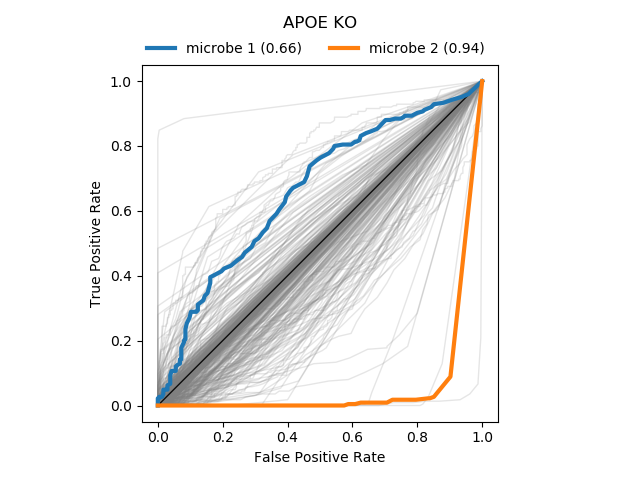

Text(0.5,1.08,'APOE KO')

In [55]:
from matplotlib import pyplot as plt
fig_apoe, ax_apoe = plt.subplots()
ax_apoe.set_aspect('equal')

fids_apoe = []

aucs = []
for i in exp2_apoe.feature_metadata.index:
    apoe_score = exp2_apoe[:, i]
    apoe_true = exp2_apoe.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(apoe_true, apoe_score)
    a = auc(fpr, tpr)
    aucs.append(a)
    if a < 0.5:
        a = 1-a
    if a > 0.75:
        fids_apoe.append(i)
    ax_apoe.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=1, color='gray', alpha=0.2)

exp2_apoe.feature_metadata['AUC'] = aucs
ax_apoe.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', alpha=.9)
ax_apoe.set_xlim(-0.05, 1.05)
ax_apoe.set_ylim(-0.05, 1.05)
ax_apoe.set_xlabel('False Positive Rate')
ax_apoe.set_ylabel('True Positive Rate')
ax_apoe.set_title('APOE KO',  y=1.08)

<IPython.core.display.Javascript object>


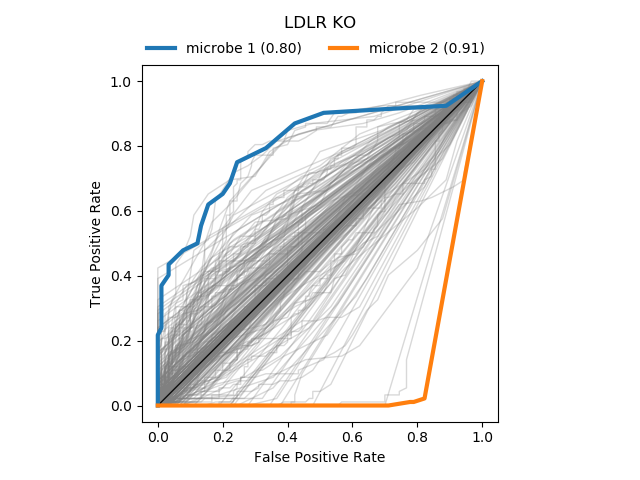

Text(0.5,1.08,'LDLR KO')

In [56]:
from matplotlib import pyplot as plt
fig_ldlr, ax_ldlr = plt.subplots()
ax_ldlr.set_aspect('equal')
fids_ldlr = []
aucs = []
for i in exp2_ldlr.feature_metadata.index:
    ldlr_score = exp2_ldlr[:, i]
    ldlr_true = exp2_ldlr.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(ldlr_true, ldlr_score)
    a = auc(fpr, tpr)
    aucs.append(a)
    if a < 0.5:
        a = 1-a
    if a > 0.75:
        fids_ldlr.append(i)
    ax_ldlr.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=1, color='gray', alpha=0.3)
exp2_ldlr.feature_metadata['AUC'] = aucs
ax_ldlr.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', alpha=.9)
ax_ldlr.set_xlim(-0.05, 1.05)
ax_ldlr.set_ylim(-0.05, 1.05)
ax_ldlr.set_xlabel('False Positive Rate')
ax_ldlr.set_ylabel('True Positive Rate')
ax_ldlr.set_title('LDLR KO',  y=1.08)

<IPython.core.display.Javascript object>


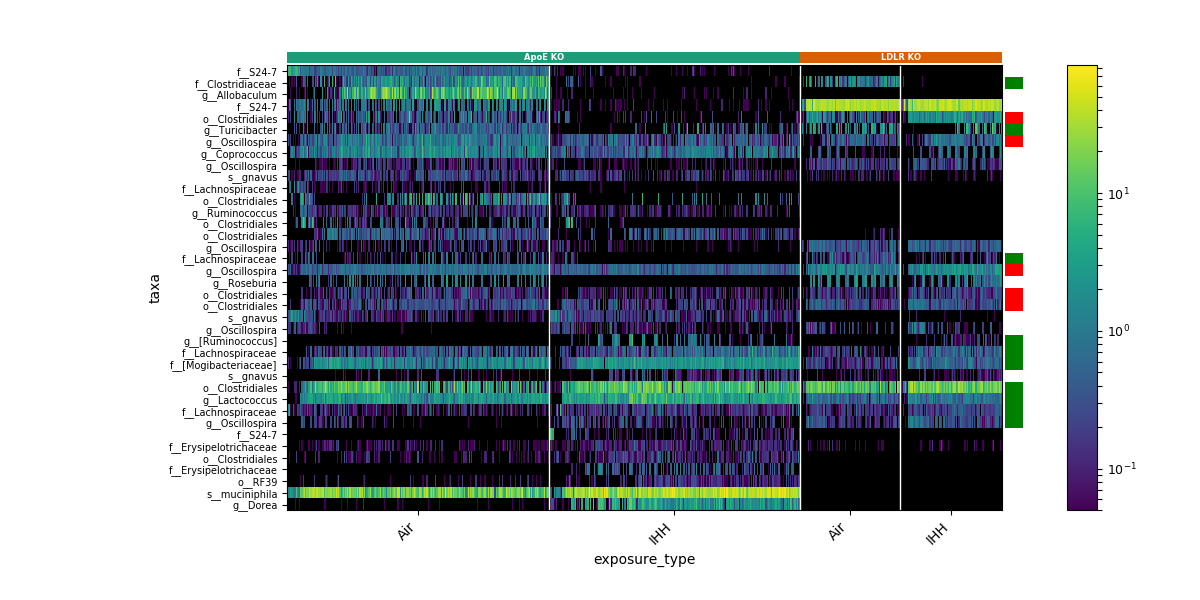

Label(value='0 features are selected')

HTML(value='no annotation found', layout=Layout(height='100px', overflow_y='auto'))

In [23]:
ids = exp2_apoe.filter_by_metadata('AUC', lambda x: [i>0.65 or i<0.35 for i in x], axis='f').sort_by_metadata('AUC', axis='f').feature_metadata.index.tolist()
exp2f = (exp2.filter_ids(ids, axis='f')
     .sort_samples('age')
     #.sort_samples('mouse_number')
     .sort_samples('exposure_type')
     .sort_samples('genotype'))

exp2f.feature_metadata['apoe_AUC'] = exp2_apoe.feature_metadata.loc[ids, 'AUC'] - 0.5
exp2f.feature_metadata['ldlr_AUC'] = exp2_ldlr.feature_metadata.loc[ids, 'AUC'] - 0.5
mask = np.abs(exp2f.feature_metadata['ldlr_AUC']) < 0.1
exp2f.feature_metadata.loc[mask, 'ldlr_AUC'] = 0
l = []
for i in exp2f.feature_metadata['apoe_AUC'] * exp2f.feature_metadata['ldlr_AUC']:
    if i > 0:
        l.append('same')
    elif i < 0:
        l.append('opposite')
    else:
        l.append(np.nan)
exp2f.feature_metadata['direction'] = l 
exp2f.get_lowest_taxonomy()
p=exp2f.plot(sample_field='exposure_type', feature_field='taxa', 
             yticklabel_len=50, yticks_max=100, yticklabel_kwargs={'size': 7},
             barx_fields=['genotype'], bary_fields=['direction'], bary_colors={'same':'green', 'opposite':'red'},
             bary_label=False, gui='jupyter')

In [18]:
exp2_apoe.feature_metadata.loc['TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAGCGTAGGCGGACTTTTAAGTGAGATGTGAAATACTCGGGCTCAACTTGAGTGCTGCATTTCAAACTGGAAGTCTAGAGTGCAGGAGAGGAGAATGGAATTCCTAG', :]

taxonomy       k__Bacteria; p__Firmicutes; c__Clostridia; o__...
Confidence                                                     1
_feature_id    TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAG...
AUC                                                    0.0598771
Name: TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAGCGTAGGCGGACTTTTAAGTGAGATGTGAAATACTCGGGCTCAACTTGAGTGCTGCATTTCAAACTGGAAGTCTAGAGTGCAGGAGAGGAGAATGGAATTCCTAG, dtype: object

In [19]:
exp2_ldlr.feature_metadata.loc['TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAGCGTAGGCGGACTTTTAAGTGAGATGTGAAATACTCGGGCTCAACTTGAGTGCTGCATTTCAAACTGGAAGTCTAGAGTGCAGGAGAGGAGAATGGAATTCCTAG', :]

taxonomy       k__Bacteria; p__Firmicutes; c__Clostridia; o__...
Confidence                                                     1
_feature_id    TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAG...
AUC                                                    0.0918478
Name: TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAGCGTAGGCGGACTTTTAAGTGAGATGTGAAATACTCGGGCTCAACTTGAGTGCTGCATTTCAAACTGGAAGTCTAGAGTGCAGGAGAGGAGAATGGAATTCCTAG, dtype: object

In [20]:
exp2_apoe.feature_metadata.loc['TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCAGCGCAAGTCTGGAGTGAAATGCCGGGGCCCAACCCCGGAACTGCTTTGGAAACTGTGCAGCTCGAGTGCAGGAGAGGTAAGCGGAATTCCTAG', :]

taxonomy       k__Bacteria; p__Firmicutes; c__Clostridia; o__...
Confidence                                              0.920555
_feature_id    TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...
AUC                                                     0.178487
Name: TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCAGCGCAAGTCTGGAGTGAAATGCCGGGGCCCAACCCCGGAACTGCTTTGGAAACTGTGCAGCTCGAGTGCAGGAGAGGTAAGCGGAATTCCTAG, dtype: object

In [21]:
exp2_ldlr.feature_metadata.loc['TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCAGCGCAAGTCTGGAGTGAAATGCCGGGGCCCAACCCCGGAACTGCTTTGGAAACTGTGCAGCTCGAGTGCAGGAGAGGTAAGCGGAATTCCTAG', :]

taxonomy       k__Bacteria; p__Firmicutes; c__Clostridia; o__...
Confidence                                              0.920555
_feature_id    TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...
AUC                                                     0.755978
Name: TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCAGCGCAAGTCTGGAGTGAAATGCCGGGGCCCAACCCCGGAACTGCTTTGGAAACTGTGCAGCTCGAGTGCAGGAGAGGTAAGCGGAATTCCTAG, dtype: object

In [24]:
p.figure.set_size_inches(12,6)
p.save_figure('apoe.pdf')

<IPython.core.display.Javascript object>


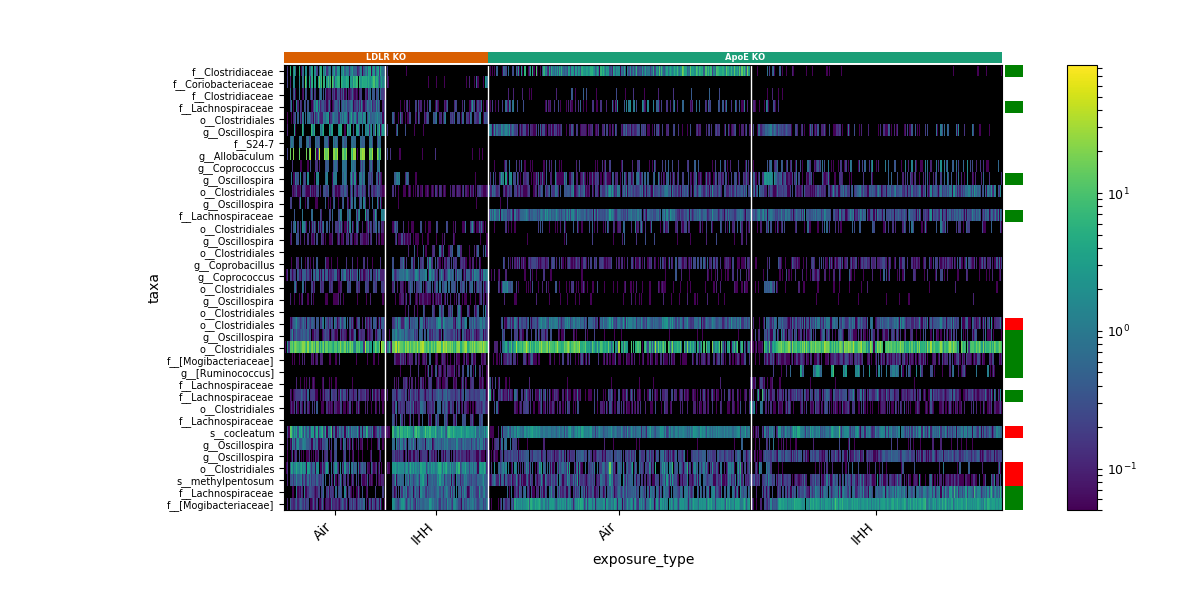

Label(value='0 features are selected')

HTML(value='no annotation found', layout=Layout(height='100px', overflow_y='auto'))

In [26]:
ids = exp2_ldlr.filter_by_metadata('AUC', lambda x: [i>0.65 or i<0.35 for i in x], axis='f').sort_by_metadata('AUC', axis='f').feature_metadata.index.tolist()

exp2f = (exp2.filter_ids(ids, axis='f')
     .sort_samples('age')
     #.sort_samples('mouse_number')
     .sort_samples('exposure_type')
     .sort_samples('genotype', reverse=True))

exp2f.feature_metadata['apoe_AUC'] = exp2_apoe.feature_metadata.loc[ids, 'AUC'] - 0.5
exp2f.feature_metadata['ldlr_AUC'] = exp2_ldlr.feature_metadata.loc[ids, 'AUC'] - 0.5
mask = np.abs(exp2f.feature_metadata['apoe_AUC']) < 0.1
exp2f.feature_metadata.loc[mask, 'apoe_AUC'] = 0
l = []
for i in exp2f.feature_metadata['apoe_AUC'] * exp2f.feature_metadata['ldlr_AUC']:
    if i > 0:
        l.append('same')
    elif i < 0:
        l.append('opposite')
    else:
        l.append(np.nan)
exp2f.feature_metadata['direction'] = l 
exp2f.get_lowest_taxonomy()
p = exp2f.plot(sample_field='exposure_type', feature_field='taxa', yticklabel_len=50, yticks_max=100, yticklabel_kwargs={'size': 7},
               barx_fields=['genotype'], bary_fields=['direction'], bary_colors={'same':'green', 'opposite':'red'}, bary_label=False, gui='jupyter')

In [27]:
p.figure.set_size_inches(12,6)
p.save_figure('ldlr.pdf')

In [50]:
fids = ['TACGTAGGGGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGTACGTAGGTGGCAACCTAAGCGCAGGGTTTAAGGCAATGGCTCAACCATTGTTCGCCCTGCGAACTGGGATGCTTGAGTGCAGGAGAGGAAAGCGGAATTCCTAGT',
        'TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAGCGTAGGCGGACTTTTAAGTGAGATGTGAAATACTCGGGCTCAACTTGAGTGCTGCATTTCAAACTGGAAGTCTAGAGTGCAGGAGAGGAGAATGGAATTCCTAG']

In [57]:
for n, (i, c) in enumerate(zip(fids, plt.cm.tab10.colors), 1):
    apoe_score = exp2_apoe[:, i]
    apoe_true = exp2_apoe.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(apoe_true, apoe_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    ax_apoe.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=3, color=c, label='microbe %d (%.2f)' % (n, a))
ax_apoe.legend(bbox_to_anchor=(0.0, 1.01), ncol=2, borderaxespad=0, frameon=False, loc="lower left")
fig_apoe.tight_layout()

<IPython.core.display.Javascript object>


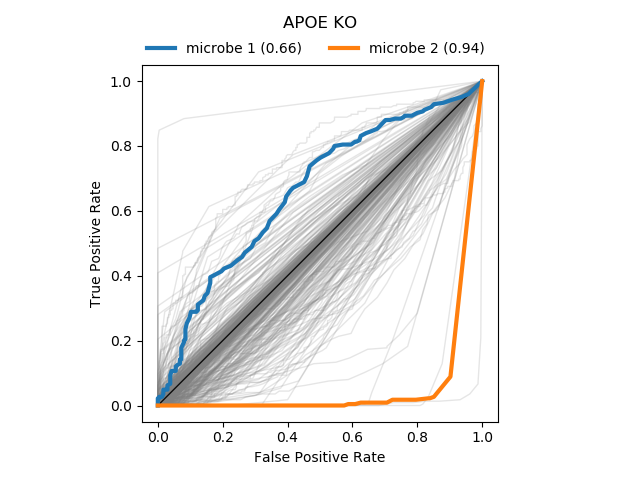

In [58]:
fig_apoe

In [59]:
for n, (i, c) in enumerate(zip(fids, plt.cm.tab10.colors), 1):
    ldlr_score = exp2_ldlr[:, i]
    ldlr_true = exp2_ldlr.sample_metadata['exposure_type'].values == 'IHH'
    fpr, tpr, thresholds = roc_curve(ldlr_true, ldlr_score)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1-a
    ax_ldlr.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), lw=3, color=c, label='microbe %d (%.2f)' % (n, a))
ax_ldlr.legend(bbox_to_anchor=(0.0, 1.01), ncol=2, borderaxespad=0, frameon=False,  loc="lower left")
fig_ldlr.tight_layout()

<IPython.core.display.Javascript object>


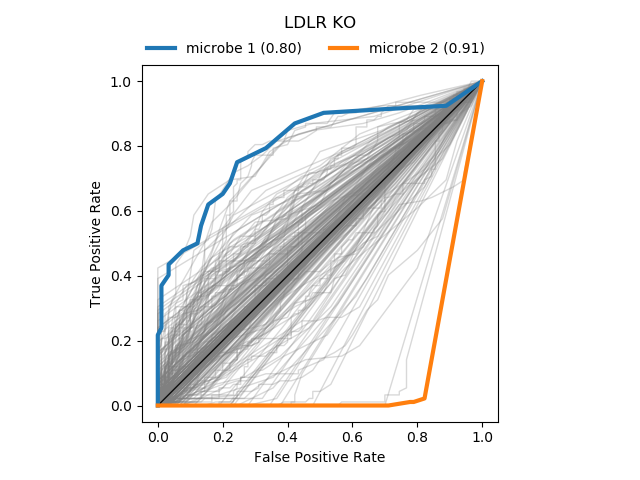

In [60]:
fig_ldlr

In [61]:
with PdfPages('roc-microbes2.pdf') as pdf:
    pdf.savefig(fig_apoe)
    pdf.savefig(fig_ldlr)